In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import Word
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import load_model
import spacy
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import fmin, tpe, hp, Trials

import os
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r'...\IMDB Dataset.csv')

data.head()

In [93]:
class DataReview:
    """Class for describing the dataset"""
    
    def __init__(self, data):
        self.data = data

    def describe_dataset(self):
        return self.data.describe()

    def balance_sentiments(self):
        return self.data.iloc[:,-1].value_counts()
    
class DataCleaner:
    """Class for cleaning and preprocessing text data."""

    @staticmethod
    def strip_html(text):
        """
        Remove HTML tags from text.

        Parameters:
        - text (str or None): Input text containing HTML tags.

        Returns:
        - str: Cleaned text without HTML tags.
        """
        if text is not None:
            soup = BeautifulSoup(text, "html.parser")
            return soup.get_text()
        else:
            return ""

    @staticmethod
    def remove_special_characters(text, remove_digits=True):
        """
        Remove special characters from text.

        Parameters:
        - text (str or None): Input text containing special characters.
        - remove_digits (bool): Flag to remove digits or not.

        Returns:
        - str: Text with special characters removed.
        """
        if text is not None:
            return re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Corrected regex and added 'Z' for uppercase letters
        else:
            return ""

    @staticmethod
    def convert_to_lowercase(text):
        """
        Convert text to lowercase.

        Parameters:
        - text (str or None): Input text.

        Returns:
        - str: Text in lowercase or an empty string if input is None.
        """
        return text.lower() if text is not None else ""

class TextProcessor:
    """Class for text processing tasks such as tokenization, stemming, and stopwords removal."""

    def __init__(self):
        self.tokenizer = RegexpTokenizer(r'\b\w+\b')
        self.snowball_stemmer = SnowballStemmer("english")
        self.stopword_list = set(stopwords.words('english'))  # Converted list to set for faster lookup

    def snowball_stemmer_function(self, text):
        """
        Apply Snowball stemming to a given text.

        Parameters:
        - text (str or None): Input text.

        Returns:
        - str: Text after Snowball stemming or an empty string if input is None.
        """
        if text is not None:
            tokens = self.tokenizer.tokenize(text)
            stemmed_text = ' '.join([self.snowball_stemmer.stem(word) for word in tokens])
            return stemmed_text
        else:
            return ""

    def remove_stopwords(self, text, is_lower_case=True):
        """
        Remove stopwords from a given text.

        Parameters:
        - text (str or None): Input text.
        - is_lower_case (bool): Flag to convert text to lowercase.

        Returns:
        - str: Text with stopwords removed or an empty string if input is None.
        """
        if text is not None:
            if is_lower_case:
                text = text.lower()
            tokens = self.tokenizer.tokenize(text)
            tokens = [token.strip() for token in tokens]
            filtered_tokens = [token for token in tokens if token not in self.stopword_list]
            filtered_text = ' '.join(filtered_tokens)
            return filtered_text
        else:
            return ""

    def apply_spelling_correction(self, text):
        """
        Apply spelling correction using TextBlob.

        Parameters:
        - text (str or None): Input text.

        Returns:
        - str: Text after spelling correction or an empty string if input is None.
        """
        if text is not None:
            corrected_text_blob = TextBlob(text).correct()
            return str(corrected_text_blob)
        else:
            return ""
           
    @staticmethod
    def spacy_lemmatizer(text):
        nlp = spacy.load('en_core_web_sm')
        doc = nlp(text)
        lemmatized_text = ' '.join([token.lemma_ for token in doc])
        return lemmatized_text

class ReviewLengthAnalyzer:
    """Class for analyzing and visualizing the distribution of review lengths."""

    def analyze_review_lengths(self, data):
        """
        Analyze and visualize the distribution of review lengths.

        Parameters:
        - data (pandas.DataFrame): Input data with a 'review' column.
        """
        review_lengths = data['review'].apply(len)
        
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(review_lengths, bins=100, color='skyblue', edgecolor='black')
        plt.title('Distribution of Review Lengths')
        plt.xlabel('Review Length')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

class SentimentAnalysisPreprocessor:
    """Class for preprocessing sentiment analysis data."""

    def __init__(self, data):
        """
        Initialize the preprocessor with input data.

        Parameters:
        - data (pandas.DataFrame): Input data with 'review' and 'sentiment' columns.
        """
        self.data = data
        self.data_cleaner = DataCleaner()
        self.text_processor = TextProcessor()
        self.review_length_analyzer = ReviewLengthAnalyzer()
        self.lb = LabelBinarizer()

    def get_normalized_reviews(self):
        """
        Get normalized reviews for sentiment analysis.

        Returns:
        - list: List of normalized words from all reviews.
        """
        norm_reviews = self.data['review']
        #norm_reviews = norm_reviews.apply(self.text_processor.apply_spelling_correction)
        norm_reviews = norm_reviews.apply(self.data_cleaner.strip_html)
        norm_reviews = norm_reviews.apply(self.data_cleaner.remove_special_characters)
        norm_reviews = norm_reviews.apply(self.text_processor.snowball_stemmer_function)
        #norm_reviews = norm_reviews.apply(self.text_processor.remove_stopwords)
        norm_reviews = norm_reviews.apply(self.text_processor.spacy_lemmatizer)  

        return norm_reviews

    def analyze_review_lengths(self):
        """Analyze and visualize the distribution of review lengths in the data."""
        self.review_length_analyzer.analyze_review_lengths(self.data)
    
    def label_sentiment_data(self):
        """
        Label sentiment data using the SentimentAnalyzer.

        Returns:
        - numpy.ndarray: Array of labeled sentiment data.
        """
        sentiment_data = self.lb.fit_transform(self.data.sentiment)
        return sentiment_data
    
    def vectorize_tfidf(self, train_size=0.8):
        """
        Vectorize text data using TF-IDF representation.

        Parameters:
        - train_size (float): Percentage of data to be used for training.

        Returns:
        - tuple: TF-IDF representation of training and testing reviews.
        """
        norm_reviews = self.get_normalized_reviews()
        sentiment_data = self.label_sentiment_data()

        # Split the data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(norm_reviews, sentiment_data, train_size = train_size)

        # TF-IDF Vectorization
        tv = TfidfVectorizer(min_df=0.0, max_df=1, use_idf=True, ngram_range=(1, 3))
        tv_reviews = tv.fit_transform(X_train)
        X_train_bow = tv.transform(X_train)
        X_test_bow = tv.transform(X_test)

        return norm_reviews, X_train_bow, X_test_bow, y_train, y_test

Dataset Summary:
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

Sentiment Balance:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


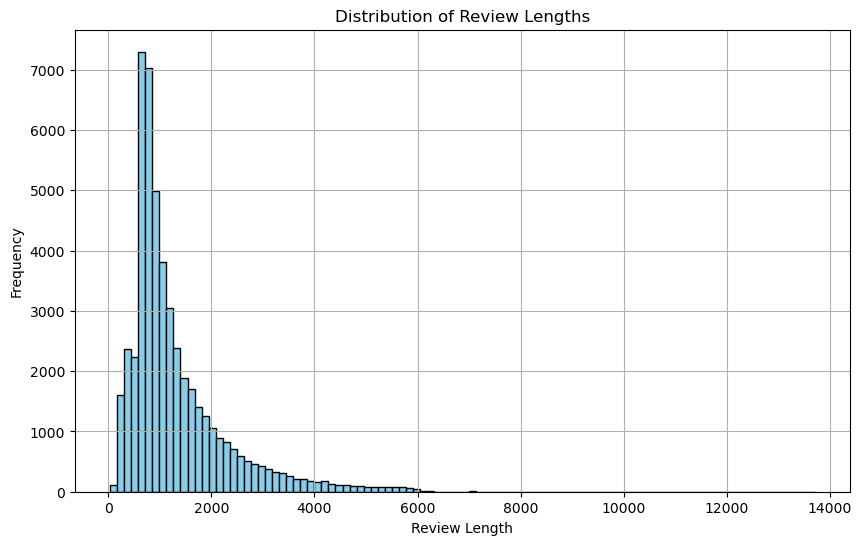

An example of a transformed review:

a wonder littl product the film techniqu be veri unassum veri oldtimebbc fashion and give a comfort and sometim discomfort sen of realism to the entir piec the actor be extrem well choose michael sheen not onli have get all the polari but he have all the voic down pat too you can truli see the seamless edit guid by the refer to william diari entri not onli be it well worth the watch but it be a terrif write and perform piec a master product about one of the great master of comedi and his life the realism realli come home with the littl thing the fantasi of the guard which rather than use the tradit dream techniqu remain solid then disappear it play on our knowledg and our sen particular with the scene concern orton and halliwel and the set particular of their flat with halliwel mural decor everi surfac be terribl well do


In [94]:
data_review = DataReview(data)

# Describe the dataset
print("Dataset Summary:")
print(data_review.describe_dataset())

# Balance of sentiments
print("\nSentiment Balance:")
print(data_review.balance_sentiments())

# Instantiate TextProcessor to use its instance methods
preprocessor = SentimentAnalysisPreprocessor(data)

# Analyze and visualize the distribution of review lengths
preprocessor.analyze_review_lengths()

# Label the target variable 
sentiment_data = preprocessor.label_sentiment_data()

# Vectorize text data using TF-IDF representation
norm_reviews, X_train_bow, X_test_bow, y_train, y_test = preprocessor.vectorize_tfidf()
print(f"An example of a transformed review:\n\n{norm_reviews[1]}")

In [95]:
# Logistic Regression
lr=LogisticRegression()
mnb_tfidf = MultinomialNB()
svm_model_tfidf = SVC()

#Fitting the model for tfidf features
lr_tfidf=lr.fit(X_train_bow,y_train)
mnb_tfidf.fit(X_train_bow, y_train)
svm_model_tfidf.fit(X_train_bow, y_train)

#Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(X_test_bow)
mnb_tfidf_predict = mnb_tfidf.predict(X_test_bow)
svm_tfidf_predict = svm_model_tfidf.predict(X_test_bow)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

# Accuracy score for tfidf features
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("mnb_tfidf_score:", mnb_tfidf_score)

# Accuracy score for tfidf features
svm_tfidf_score = accuracy_score(y_test, svm_tfidf_predict)
print("svm_tfidf_score:", svm_tfidf_score)

lr_tfidf_score : 0.7544
mnb_tfidf_score: 0.7547
svm_tfidf_score: 0.5108


In [96]:
# Multinomial Naive Bayes for tfidf features
# Function to optimize using Hyperopt
def objective(params):
    alpha = params['alpha']
    fit_prior = params['fit_prior']
    class_prior = params['class_prior']
    
    # Create Multinomial Naive Bayes model with the given alpha
    mnb = MultinomialNB(alpha=alpha,
                        fit_prior=fit_prior,
                        class_prior=class_prior
                       )
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(mnb, X_train_bow, y_train, cv=10, scoring='roc_auc')
    
    # Return the negative accuracy (as Hyperopt minimizes the objective)
    return -np.mean(scores)

n_classes = len(np.unique(y_train))

# Define the search space for hyperparameters
space = {
    'alpha': hp.uniform('alpha', 0.1, 10),
    'fit_prior': hp.choice('fit_prior', [True, False]),
    'class_prior': hp.choice('class_prior', [None, [0.1,]* n_classes])
                              }

# Initialize Trials object to track the progress
trials = Trials()

# Run Hyperopt optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials, rstate=np.random.default_rng(42))

# Extract the best hyperparameters
best_alpha = best['alpha']
best_fit_prior = [True,False][best['fit_prior']]
best_class_prior = [None, [0.1,]* n_classes][best['class_prior']]
                              
# Train Multinomial Naive Bayes models with the best hyperparameters
mnb_bow = MultinomialNB(alpha=best_alpha,
                        fit_prior=best_fit_prior,
                        class_prior=best_class_prior
                       )
mnb_bow.fit(X_train_bow, y_train)

# Predicting the models for bag of words and tfidf features
mnb_bow_predict = mnb_bow.predict(X_test_bow)

# Accuracy score for bag of words
mnb_bow_score = accuracy_score(y_test, mnb_bow_predict)
print("mnb_bow_score:", mnb_bow_score)

100%|█████████████████████████████████████████████| 200/200 [19:22<00:00,  5.81s/trial, best loss: -0.4914143121026967]
mnb_bow_score: 0.7553


# Sentiment Analysis using BERT

In [98]:
from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


class BertSentimentAnalysis:
    def __init__(self, df, model_name="bert-base-uncased", max_length=128):
        self.df = df
        self.model = TFBertForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.max_length = max_length

    def target_label(self, value):
        return 1 if value == 'positive' else 0

    def preprocess_data(self):
        self.df['sentiment'] = self.df['sentiment'].apply(self.target_label)
        train, test = train_test_split(self.df, test_size=0.2, random_state=42)
        return train, test

    def examples_transformation(self, data, review_col, sentiment_col):
        examples = data.apply(lambda x: InputExample(guid=None, text_a=x[review_col], label=x[sentiment_col]), axis=1)
        return examples

    def examples_tf(self, examples):
        features = []

        for example in examples:
            input_dict = self.tokenizer.encode_plus(
                example.text_a,
                add_special_tokens=True,
                max_length=self.max_length,
                return_token_type_ids=True,
                return_attention_mask=True,
                pad_to_max_length=True,
                truncation=True
            )
            input_ids, token_type_ids, attention_mask = (input_dict["input_ids"], input_dict["token_type_ids"], input_dict['attention_mask'])
            features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=example.label))

        def generator():
            for feature in features:
                yield (
                    {
                        "input_ids": feature.input_ids,
                        "attention_mask": feature.attention_mask,
                        "token_type_ids": feature.token_type_ids,
                    },
                    feature.label,
                )

        return tf.data.Dataset.from_generator(
            generator,
            ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
            (
                {
                    "input_ids": tf.TensorShape([None]),
                    "attention_mask": tf.TensorShape([None]),
                    "token_type_ids": tf.TensorShape([None]),
                },
                tf.TensorShape([]),
            ),
        )


In [108]:
# Create an instance of the BertSentimentAnalysis class
sentiment_analysis = BertSentimentAnalysis(data)

# Preprocess the data
train_data, test_data = sentiment_analysis.preprocess_data()

# Transform examples for training and testing
train_examples = sentiment_analysis.examples_transformation(train_data, 'review', 'sentiment')
test_examples = sentiment_analysis.examples_transformation(test_data, 'review', 'sentiment')

# Convert examples to TF datasets
train_dataset = sentiment_analysis.examples_tf(train_examples)
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)

test_dataset = sentiment_analysis.examples_tf(test_examples)
test_dataset = test_dataset.batch(32)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Load BERT model and tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

# Accuracy Before Training
accuracy_before_training = model.evaluate(test_dataset)[1] 

# Train
model.fit(train_dataset, epochs=2, validation_data=test_dataset)

# Accuracy After Training
accuracy_after_training = model.evaluate(test_dataset)[1] 

157/157 [==============================] - 2206s 14s/step - loss: 0.7309 - accuracy: 0.5060
Epoch 1/2
2814/2814 [==============================] - 121159s 43s/step - loss: 0.2423 - accuracy: 0.8992 - val_loss: 0.2751 - val_accuracy: 0.9004
Epoch 2/2
157/157 [==============================] - 1375s 9s/step - loss: 0.4748 - accuracy: 0.8860


In [12]:
# Results
print(f'Accuracy Before Training: {accuracy_before_training}')
print(f'Accuracy After Training: {accuracy_after_training}')

Accuracy Before Training: 0.5059999823570251
Accuracy After Training: 0.8859999775886536
